In [1]:
%matplotlib ipympl
import time
import traceback
from onix.data_tools import get_experiment_data
from functools import partial
from onix.analysis.fitter import Fitter
from onix.analysis.helper import group_and_average_data
import numpy as np
from matplotlib import colormaps
import matplotlib.pyplot as plt
from scipy.integrate import quad
from scipy.special import voigt_profile
import allantools

In [2]:
def p_excited(t, Omega, delta, tau):
    Omega_gen = np.sqrt(Omega**2 + delta**2)
    offset = Omega ** 2 / Omega_gen ** 2 / 2
    return offset + (Omega ** 2 / Omega_gen ** 2 * np.sin(Omega_gen * t / 2) ** 2 - offset) * np.exp(-t / tau)

span = 30e3*2*np.pi
def uniform_inhomogenous_broadening(delta):
    return np.heaviside(span - delta, 0.5) * np.heaviside(delta + span, 0.5) / (2 * span)
    
def p_excited_with_inhomogenous(t, a, Omega, tau, c):
    def integrand(delta):
        return p_excited(t, Omega, delta, tau) * uniform_inhomogenous_broadening(delta)
    return a * quad(integrand, -span, span)[0] + c
    
def p_excited_with_inhomogenous_1(t, Omega, a, tau, c, scale_factor):
    def integrand(delta):
        return p_excited(t, Omega * scale_factor, delta, tau) * uniform_inhomogenous_broadening(delta)
    return a * quad(integrand, -span, span)[0] + c

In [3]:
def gaussian(f, f_0, a, sigma, b, c):
    numerator = (f - f_0) ** 2
    denominator = 2 * sigma ** 2
    return a * np.exp(-numerator / denominator) + c + b * (f - f_0)

def get_gaussian_fit(detunings, voltages, p0=None):
    fitter = Fitter(gaussian)
    fitter.set_absolute_sigma(False)
    fitter.set_data(detunings, voltages)
    fitter.set_p0({"f_0": 0})
    #fitter.set_bounds("a", -np.inf, 0)
    #fitter.set_bounds("c", 0, np.inf)
    #fitter.set_p0({"a": -1})
    if p0 is not None:
        fitter.set_p0(p0)
    fitter.fit()
    
    return fitter

def gaussian0(f, f0, a, sigma): 
    return a * np.exp( -(f - f0) **2 / (2 * sigma ** 2) )

def four_peak_gaussian(f, f1, f2, f3, f4, a1, a2, a3, a4, sigma1, sigma2, sigma3, sigma4):
    return gaussian0(f, f1, a1, sigma1) + gaussian0(f, f2, a2, sigma2) + gaussian0(f, f3, a3, sigma3) + gaussian0(f, f4, a4, sigma4) + c

def linear(x, a, b):
    return x * a + b

In [4]:
def averaged_data_from_number(data_number):
    data, headers = get_experiment_data(data_number)
    transmissions_avg = group_and_average_data(data["transmissions_avg"], headers["params"]["detect"]["cycles"])
    monitors_avg = group_and_average_data(data["monitors_avg"], headers["params"]["detect"]["cycles"])
    return (transmissions_avg, monitors_avg, headers)

In [5]:
def gaussian_fits_from_data(transmissions_avg, monitors_avg, headers, default_p0=None):
    antihole_avg = transmissions_avg["antihole"]
    rf_avg = transmissions_avg["rf"]
    if "chasm" in transmissions_avg:
        chasm_avg = transmissions_avg["chasm"]
        antihole_normalized = antihole_avg / chasm_avg
        rf_normalized = rf_avg / chasm_avg
    else:
        antihole_normalized = antihole_avg
        rf_normalized = rf_avg

    detunings = headers["detunings"].to("MHz").magnitude
    use_field_plate = headers["params"]["field_plate"]["use"]
    positive_field_plate = headers["params"]["field_plate"]["amplitude"] > 0

    p0 = {"sigma": 0.3}
    if default_p0 is None:
        default_p0 = {}
    p0.update(default_p0)
    
    if not use_field_plate:
        fits = {0: {}}
        antihole_fit = get_gaussian_fit(detunings, antihole_normalized, p0=p0)
        fits[0]["ah"] = antihole_fit
        
        rf_fit = get_gaussian_fit(detunings, rf_normalized, p0=p0)
        fits[0]["rf"] = rf_fit
    else:
        fits = {1: {}, -1: {}}
        for label in [1, -1]:
            positive_stark_shift = (label * positive_field_plate) > 0
            if positive_stark_shift:
                mask = detunings > 0
            else:
                mask = detunings < 0
            antihole_fit = get_gaussian_fit(detunings[mask], antihole_normalized[mask], p0=p0)
            fits[label]["ah"] = antihole_fit
            
            rf_fit = get_gaussian_fit(detunings[mask], rf_normalized[mask], p0=p0)
            fits[label]["rf"] = rf_fit
    return fits

In [6]:
def ah_parameters_from_data(transmissions_avg, monitors_avg, headers):
    antihole_avg = transmissions_avg["antihole"]
    rf_avg = transmissions_avg["rf"]
    if "chasm" in transmissions_avg:
        chasm_avg = transmissions_avg["chasm"]
        antihole_normalized = antihole_avg / chasm_avg
        rf_normalized = rf_avg / chasm_avg
    else:
        antihole_normalized = antihole_avg
        rf_normalized = rf_avg

    detunings = headers["detunings"].to("MHz").magnitude
    use_field_plate = headers["params"]["field_plate"]["use"]
    positive_field_plate = headers["params"]["field_plate"]["amplitude"] > 0
    
    if not use_field_plate:
        off_resonant_index = np.argmax(np.abs(detunings) > 0)
        on_resonant_index = 1 - off_resonant_index
        heights = {0: {}}
        backgrounds = {0: {}}
        heights[0]["ah"] = 1 - antihole_avg[on_resonant_index] / antihole_avg[off_resonant_index]
        heights[0]["rf"] = 1 - rf_avg[on_resonant_index] / rf_avg[off_resonant_index]
        backgrounds[0]["ah"] = antihole_avg[off_resonant_index]
        backgrounds[0]["rf"] = rf_avg[off_resonant_index]
    else:
        raise NotImplementedError()
    return (heights, backgrounds)

In [293]:
def ah_parameters_from_data1(data_number):
    data, headers = get_experiment_data(data_number)
    cycles = headers["params"]["detect"]["cycles"]
    total_cycles = sum(cycles.values())
    remainder_to_label = {}
    for kk in range(total_cycles):
        last_index_of_label = 0
        for label in cycles:
            if cycles[label] > 0:
                last_index_of_label += cycles[label]
                if kk < last_index_of_label:
                    remainder_to_label[kk] = label
                    break
    data_averages = {}
    for label in cycles:
        if cycles[label] > 0:
            data_averages[label] = []
    for kk in range(len(data["transmissions_avg"])):
        remainder = kk % total_cycles
        data_averages[remainder_to_label[remainder]].append(data["transmissions_avg"][kk])

    # antihole_avg = np.average(data_averages["antihole"], axis=0)
    # rf_avg = np.average(data_averages["rf"], axis=0)
    antihole_avg = np.array(data_averages["antihole"])
    rf_avg = np.array(data_averages["rf"])
    if "chasm" in data_averages:
        chasm_avg = data_averages["chasm"]
        antihole_normalized = antihole_avg / chasm_avg
        rf_normalized = rf_avg / chasm_avg
    else:
        antihole_normalized = antihole_avg
        rf_normalized = rf_avg

    detunings = headers["detunings"].to("MHz").magnitude
    use_field_plate = headers["params"]["field_plate"]["use"]
    positive_field_plate = headers["params"]["field_plate"]["amplitude"] > 0
    
    if not use_field_plate:
        off_resonant_index = np.argmax(np.abs(detunings) > 0)
        on_resonant_index = 1 - off_resonant_index
        heights = {0: {}}
        backgrounds = {0: {}}
        heights[0]["ah"] = np.average(1 - antihole_avg[:, on_resonant_index] / antihole_avg[:, off_resonant_index])
        heights[0]["rf"] = np.average(1 - rf_avg[:, on_resonant_index] / rf_avg[:, off_resonant_index])
        backgrounds[0]["ah"] = np.average(antihole_avg[off_resonant_index])
        backgrounds[0]["rf"] = np.average(rf_avg[off_resonant_index])
        # heights[0]["ah"] = 1 - np.average(antihole_avg[on_resonant_index]) / np.average(antihole_avg[off_resonant_index])
        # heights[0]["rf"] = 1 - np.average(rf_avg[on_resonant_index]) / np.average(rf_avg[off_resonant_index])
        # backgrounds[0]["ah"] = np.average(antihole_avg[off_resonant_index])
        # backgrounds[0]["rf"] = np.average(rf_avg[off_resonant_index])
    else:
        raise NotImplementedError()
    return (heights, backgrounds)

In [590]:
def rf_spectroscopy_ah_ratio(data_numbers, method="auto"):
    rf_heights = {}
    antihole_heights = {}
    rf_backgrounds = {}
    antihole_backgrounds = {}
    headers = []
    for data_number in data_numbers:
        transmissions_avg, monitors_avg, headers_single = averaged_data_from_number(data_number)
        if method == "auto":
            detunings_len = len(headers_single["detunings"])
            if detunings_len > 4:
                method = "fit"
            else:
                method = "ratio"
        if method == "fit":
            try:
                fits = gaussian_fits_from_data(transmissions_avg, monitors_avg, headers_single)
            except RuntimeError as e:
                print(f"Fitting error for data number #{data_number}:")
                raise e
            for label in fits:
                if label not in rf_heights:
                    rf_heights[label] = []
                    antihole_heights[label] = []
                    rf_backgrounds[label] = []
                    antihole_backgrounds[label] = []
                rf_heights[label].append(fits[label]["rf"].results["a"] / fits[label]["rf"].results["c"])
                antihole_heights[label].append(fits[label]["ah"].results["a"] / fits[label]["ah"].results["c"])
                rf_backgrounds[label].append(fits[label]["rf"].results["c"])
                antihole_backgrounds[label].append(fits[label]["ah"].results["c"])
        elif method == "ratio":
            heights, backgrounds = ah_parameters_from_data(transmissions_avg, monitors_avg, headers_single)
            # heights, backgrounds = ah_parameters_from_data1(data_number)
            for label in heights:
                if label not in rf_heights:
                    rf_heights[label] = []
                    antihole_heights[label] = []
                    rf_backgrounds[label] = []
                    antihole_backgrounds[label] = []
                rf_heights[label].append(heights[label]["rf"])
                antihole_heights[label].append(heights[label]["ah"])
                rf_backgrounds[label].append(backgrounds[label]["rf"])
                antihole_backgrounds[label].append(backgrounds[label]["ah"])
        headers.append(headers_single)
    for label in rf_heights:
        rf_heights[label] = np.array(rf_heights[label])
        antihole_heights[label] = np.array(antihole_heights[label])
        rf_backgrounds[label] = np.array(rf_backgrounds[label])
        antihole_backgrounds[label] = np.array(antihole_backgrounds[label])
    return (rf_heights, antihole_heights, rf_backgrounds, antihole_backgrounds, headers)

In [354]:
def data_identification_to_list(data_identification):
    if isinstance(data_identification, tuple):
        return range(data_identification[0], data_identification[1] + 1)
    elif isinstance(data_identification, int):
        return [data_identification]
    else:
        # it should be a list
        return data_identification

0.07851543413098938
0.06727779584612495
0.10997139540272385


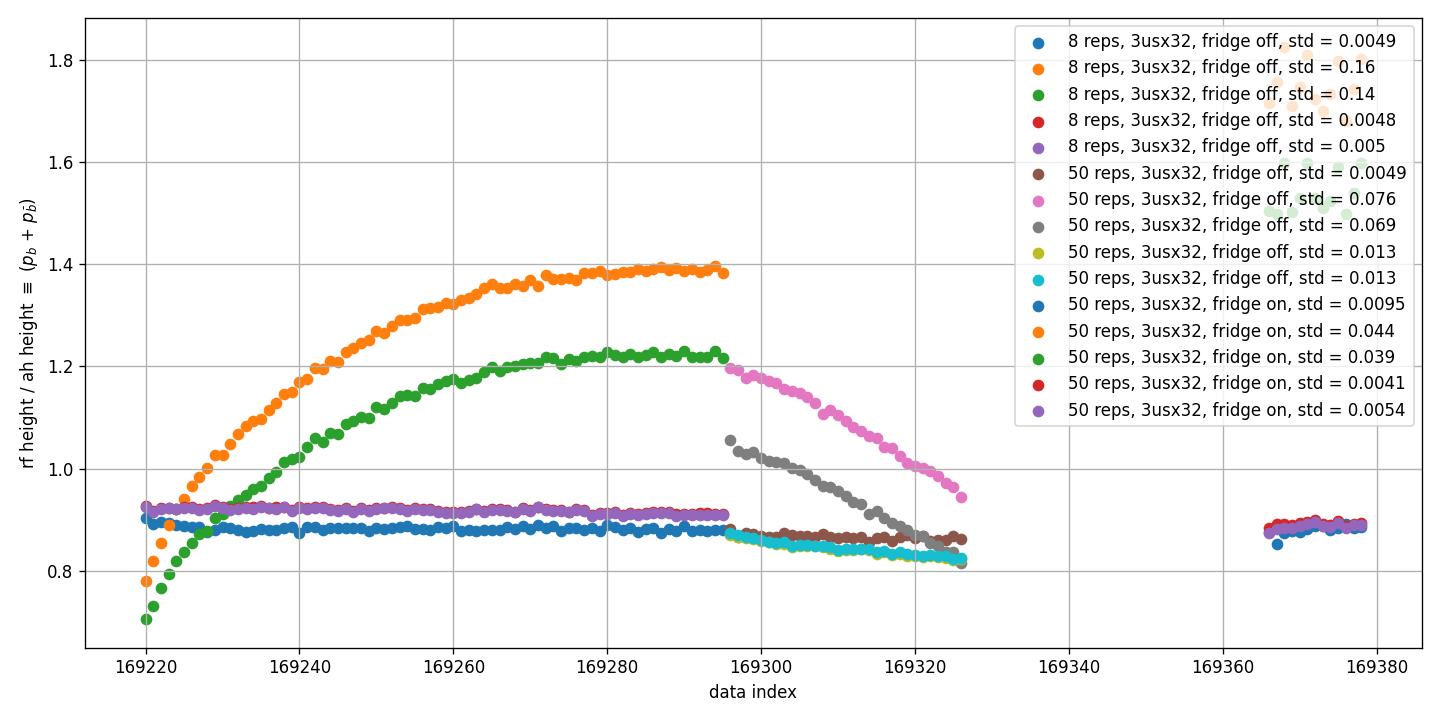

In [573]:
data = {
    # "1": (166056, 166082),
    # "2": (166083, 166101),
    # "3": (166104, 166124),
    # "4": (166125, 166136),
    # "5": (166137, 166145),
    # "6": (166146, 166161),
    # "7": (166162, 166178),
    # "8": (166179, 166201),
    # "9": (166204, 166217),
    # "10": (166221, 166258),
    # "11": (166268, 166292),
    # "12": (166293, 166307),
    # "13": (166308, 166318),
    # "14": (166325, 166403),
    # "15": (166408, 166416),
    # "16": (166423, 166432),

    # "ah 8 reps": (166696, 166747),
    # "ah 20 reps": (166748, 166801),
    # "ah 50 reps": (166802, 166824),
    # "ah 8 reps + 500 ms wait after ah": (166825, 166884),
    # "ah 8 reps + 500 ms wait after chasm": (166914, 166975),
    # "ah 8 reps again": (166976, 167020),
    # "ah 50 reps again": (167021, 167054),
    # "ah 50 reps, no inten. stab.": (167055, 167084),

    #"8 reps, 3usx32": (167366, 167637),
    #"8 reps, 50usx1": (167638, 167933),
    #"8 reps, 5usx16": (167934, 168008),
    #"8 reps, 10usx8": (168009, 168084),
    #"8 reps, 10usx4, scan": (168085, 168210),
    "8 reps, 3usx32, fridge off": (169220, 169295),
    "50 reps, 3usx32, fridge off": (169296, 169326),
    "50 reps, 3usx32, fridge on": (169366, 169378),
}
fig, ax = plt.subplots(figsize = (12, 6), dpi = 120)
for ll, (label, data_range) in enumerate(data.items()):
    data_list = data_identification_to_list(data_range)
    rf_heights, ah_heights, rf_bgs, ah_bgs, headers = rf_spectroscopy_ah_ratio(data_list)
    #xs = [header["params"]["rf"]["detuning"].to("kHz").magnitude for header in headers]
    xs = [header["data_info"]["data_number"] for header in headers]
    # ys = rf_bgs[0] / ah_bgs[0]
    # ax.scatter(xs, ys, label=label + f", std = {np.std(ys):.2g}")
    # ys = rf_bgs[0] * (1 - rf_heights[0]) / (ah_bgs[0] * (1 - ah_heights[0]))
    # ax.scatter(xs, ys, label=label + f", std = {np.std(ys):.2g}")
    ys = rf_heights[0] / (ah_heights[0])
    ax.scatter(xs, ys, label=label + f", std = {np.std(ys):.2g}")
    print(np.average(rf_heights[0]))
    ys = np.abs(ah_heights[0]) * 14
    ax.scatter(xs, ys, label=label + f", std = {np.std(ys):.2g}")
    ys = np.abs(rf_heights[0]) * 14
    ax.scatter(xs, ys, label=label + f", std = {np.std(ys):.2g}")
    ys = ah_bgs[0]
    ax.scatter(xs, ys, label=label + f", std = {np.std(ys):.2g}")
    ys = rf_bgs[0]
    ax.scatter(xs, ys, label=label + f", std = {np.std(ys):.2g}")
    
#ax.set_xlabel("RF detuning from ab Zeeman average (kHz)")
ax.set_xlabel("data index")
ax.set_ylabel("rf height / ah height $\\equiv$ ($p_b$ + $p_\\bar{b}$)")
#ax.set_ylabel("relative antihole height")
ax.legend()
ax.grid()
plt.tight_layout()
plt.show()

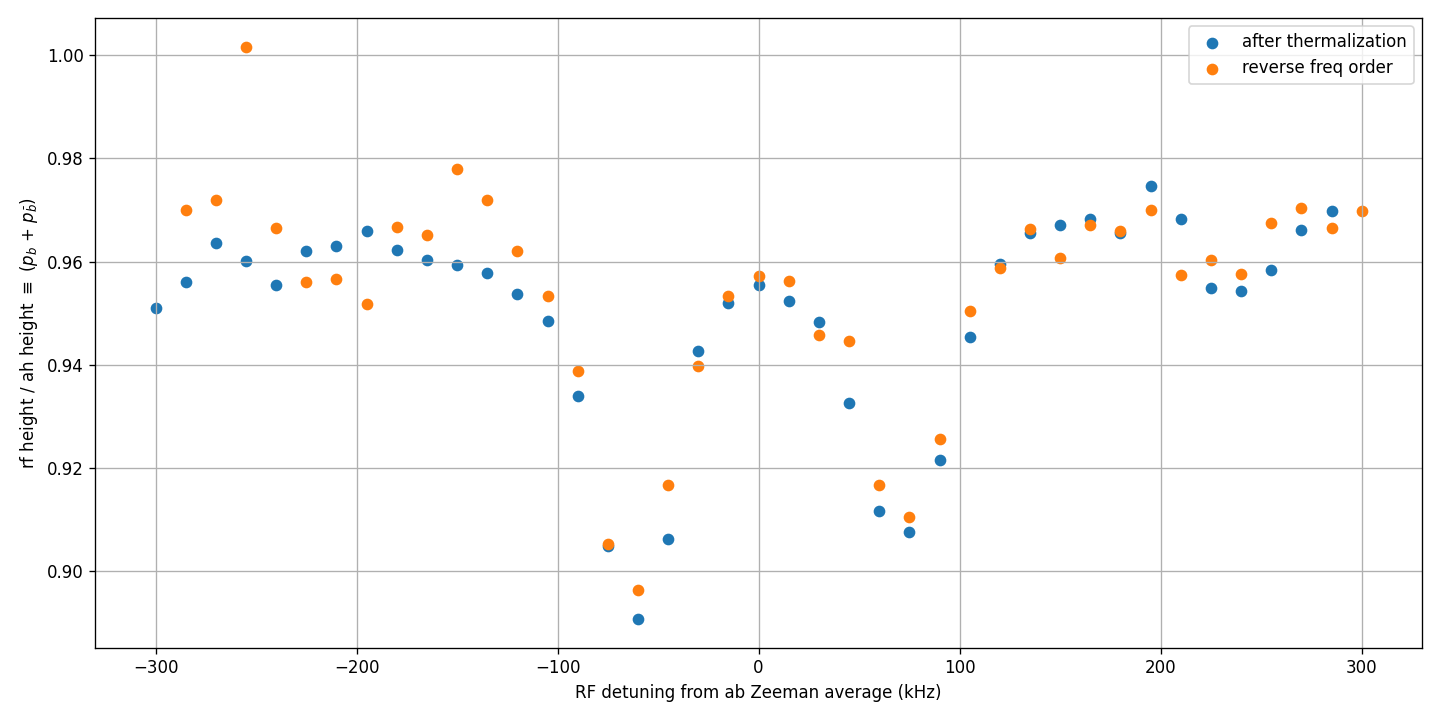

In [555]:
data = {
    #"spec": (166565, 166604),
    #"spec1": (166605, 166607),
    "after thermalization": (167284, 167323),
    "reverse freq order": (167324, 167363),
}
fig, ax = plt.subplots(figsize = (12, 6), dpi = 120)
for ll, (label, data_range) in enumerate(data.items()):
    data_list = data_identification_to_list(data_range)
    rf_heights, ah_heights, rf_bgs, ah_bgs, headers = rf_spectroscopy_ah_ratio(data_list)
    xs = [header["params"]["rf"]["detuning"].to("kHz").magnitude for header in headers]
    ys = rf_heights[0] / ah_heights[0]
    ax.scatter(xs, ys, label=label)
    # ys = ah_heights[0]
    # ax.scatter(xs, ys, label=label)
    # ys = rf_heights[0]
    # ax.scatter(xs, ys, label=label)
    # ys = ah_bgs[0]
    # ax.scatter(xs, ys, label=label)
    # ys = rf_bgs[0]
    # ax.scatter(xs, ys, label=label)
    
ax.set_xlabel("RF detuning from ab Zeeman average (kHz)")
ax.set_ylabel("rf height / ah height $\\equiv$ ($p_b$ + $p_\\bar{b}$)")
#ax.set_ylabel("relative antihole height")
ax.legend()
ax.grid()
plt.tight_layout()
plt.show()

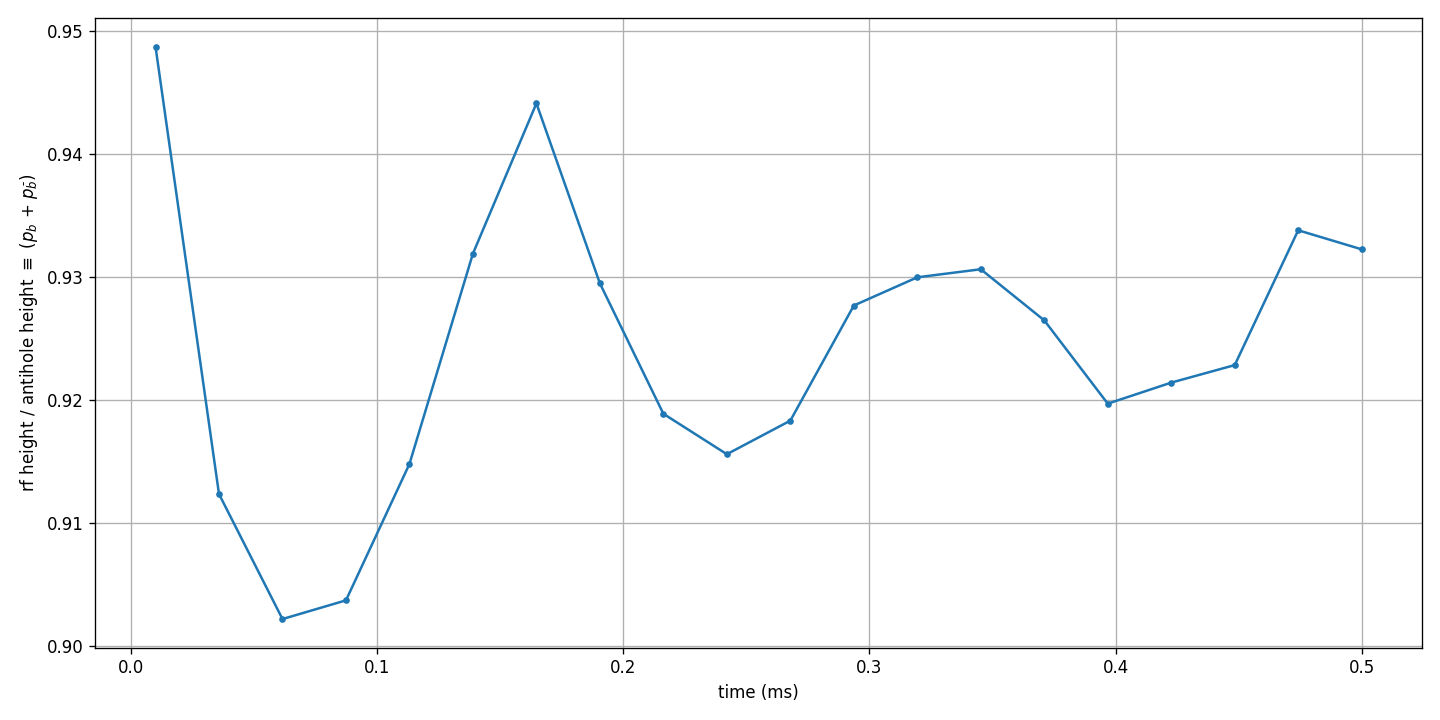

In [363]:
data = {
    # "-70 kHz, 4200": (166505, 166524),
    # "70 kHz, 4200": (166525, 166544),
    # "70 kHz, 4200, 4x": (166545, 166564),
    # "0 amplitude 1": (167183, 167202),
    # "0 amplitude 2": (167203, 167222),
    # "-70 kHz, 4200, 4, 4": (167223, 167242),
    "-70 kHz, 4200, 20, 1": (167243, 167262),
    # "-70 kHz, 4200, 20, 4": (167263, 167282),
}
fig, ax = plt.subplots(figsize = (12, 6), dpi = 120)
for ll, (label, data_range) in enumerate(data.items()):
    data_list = data_identification_to_list(data_range)
    rf_heights, ah_heights, rf_bgs, ah_bgs, headers = rf_spectroscopy_ah_ratio(data_list)
    xs = [header["params"]["rf"]["duration"].to("ms").magnitude for header in headers]
    #xs = [header["data_info"]["data_number"] for header in headers]
    ys = rf_heights[0] / ah_heights[0]
    ax.plot(xs, ys, '.-', label=label)
    # ys = ah_heights[0]
    # ax.scatter(xs, ys, label=label)
    # ys = rf_heights[0]
    # ax.scatter(xs, ys, label=label)
    # ys = ah_bgs[0]
    # ax.scatter(xs, ys, label=label)
    # ys = rf_bgs[0]
    # ax.scatter(xs, ys, label=label)

ax.set_xlabel("time (ms)")
#ax.set_xlabel("data index")
ax.set_ylabel("rf height / antihole height $\\equiv$ ($p_b$ + $p_\\bar{b}$)")
#ax.set_ylabel("relative antihole height")
# ax.legend()
ax.grid()
plt.tight_layout()
plt.show()
fig.canvas.draw()

In [2]:
data, headers = get_experiment_data(169453)

In [3]:
detunings_MHz = headers["detunings"].to("MHz").magnitude
transmissions_avg = group_and_average_data(data["transmissions_avg"], headers["params"]["detect"]["cycles"])

In [4]:
plt_monitor = False
use_positive = None

antihole_avg = transmissions_avg["antihole"]
rf_avg = transmissions_avg["rf"]
if "chasm" in transmissions_avg:
    chasm_avg = transmissions_avg["chasm"]
    antihole_normalized = antihole_avg / chasm_avg
    rf_normalized = rf_avg / chasm_avg
else:
    chasm_avg = None
    antihole_normalized = antihole_avg
    rf_normalized = rf_avg

if use_positive == True:
    mask = detunings_MHz > 0
elif use_positive == False:
    mask = detunings_MHz < 0
else:
    mask = detunings_MHz < 1e13

fig, ax = plt.subplots()
#ax.scatter(detunings_MHz, chasm_avg, label="chasm", color="C0")
ax.scatter(detunings_MHz[mask], antihole_normalized, label="antihole", color="C1")
ax.scatter(detunings_MHz[mask], rf_normalized, label="rf", color="C2")

xaxis = np.linspace(min(detunings_MHz[mask]), max(detunings_MHz[mask]), 1000)
#antihole_fit = get_gaussian_fit(detunings_MHz[mask], antihole_normalized, p0={"f_0": np.average(detunings_MHz[mask]) + 0.001, "sigma": 0.005, "a": 0.01, "c": 0.011})
#ax.plot(xaxis, antihole_fit.fitted_value(xaxis), label = "hole fit", color="C1")
#rf_fit = get_gaussian_fit(detunings_MHz[mask], rf_normalized, p0={"f_0": np.average(detunings_MHz[mask]) + 0.001})
#ax.plot(xaxis, rf_fit.fitted_value(xaxis), label = 'rf fit', color="C2")
            
ax.set_xlabel("Optical detuning (MHz)")
ax.set_ylabel("Transmission (V)")
plt.legend()
plt.tight_layout()
plt.show()

#print(antihole_fit.all_results_str())
print()
#print(rf_fit.all_results_str())

KeyError: 'antihole'

0.10774040185280309 0.122690895424593
0.10745764226768906 0.12316648157523624
0.1026339437452245 0.12347528780364736
0.08411960023278753 0.11325769807462627
0.07392842422369739 0.10797121001395105


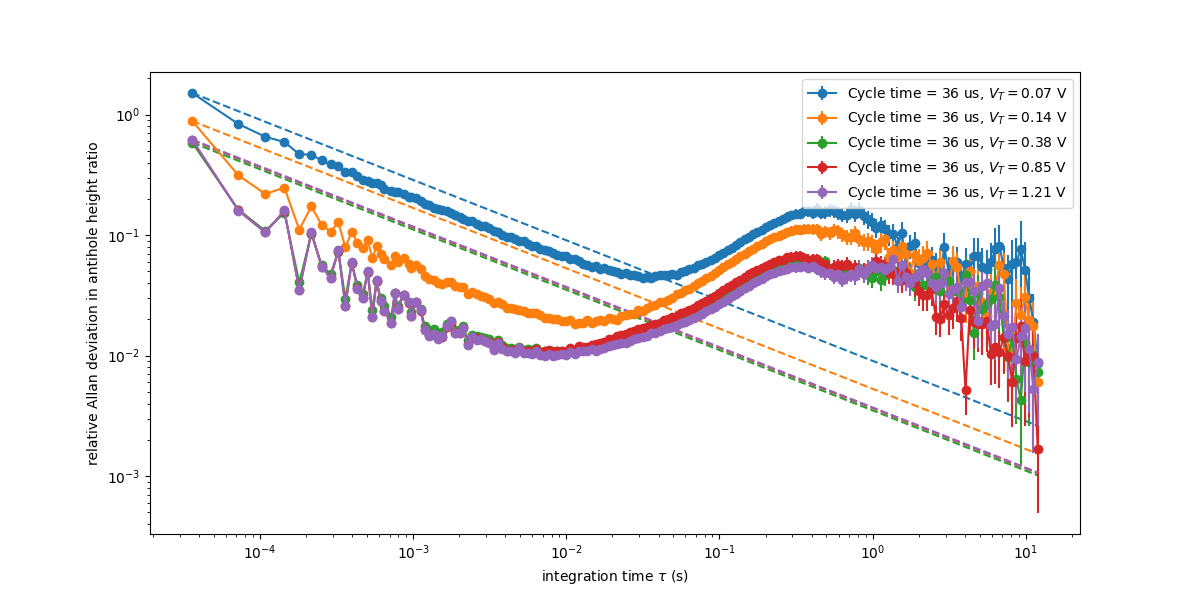

In [181]:
labels = {
    #"amp 100": 169459,
    "amp 120": 169464,
    "amp 140": 169460,
    "amp 180": 169461,
    "amp 220": 169462,
    "amp 240": 169465,
}

fig, ax = plt.subplots(figsize=(12, 6))
for kk, label in enumerate(labels):
    data, headers = get_experiment_data(labels[label])  # 169455 - amp 210, 169456 - amp 160
    cycle_time = ((headers["params"]["detect"]["on_time"] + headers["params"]["detect"]["off_time"]).to("s").magnitude) * 2 + 28e-6
    cycles = headers["params"]["detect"]["cycles"]["antihole"]
    
    times = np.arange(cycles*100) * cycle_time
    ah_ratios = data["transmissions_avg"][:cycles*100,0] / data["transmissions_avg"][:cycles*100,1]
    rf_ratios = data["transmissions_avg"][cycles*100:cycles*100*2,0] / data["transmissions_avg"][cycles*100:cycles*100*2,1]
    ratios = (1-rf_ratios) / (1-ah_ratios + 1e-18)
    print(1- np.average(rf_ratios), 1- np.average(ah_ratios))
    
    fitter = Fitter(lambda x, a, b: a * x + b)
    fitter.set_data(times, ratios)
    fitter.fit()
    ratios_no_bg = ratios - fitter.fitted_value(times) + fitter.results["b"]
    fitter.set_data(times, ah_ratios)
    fitter.fit()
    ah_ratios_no_bg = ah_ratios - fitter.fitted_value(times) + fitter.results["b"]
    fitter.set_data(times, rf_ratios)
    fitter.fit()
    rf_ratios_no_bg = rf_ratios - fitter.fitted_value(times) + fitter.results["b"]
    plot_variable = np.copy(ratios_no_bg)
    
    plot_variable /= np.average(plot_variable)
    taus = np.logspace(0, np.log10(len(plot_variable) // 3), 200)
    real_taus, allan, allan_err, _ = allantools.adev(plot_variable, data_type="freq", taus=taus)
    #allan *= np.sqrt(np.average(data["transmissions_avg"]))
    #allan_err *= np.sqrt(np.average(data["transmissions_avg"]))
    real_taus *= cycle_time
    ax.plot(real_taus, allan[0] / np.sqrt(real_taus / real_taus[0]), color=f"C{kk}", ls="--")
    ax.errorbar(real_taus, allan, allan_err, fmt="o", ls="-", label=f"Cycle time = {cycle_time*1e6:.0f} us" + ", $V_T=" + f"{np.average(data["transmissions_avg"]):.2f}$ V", color=f"C{kk}")
    
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("integration time $\\tau$ (s)")
ax.set_ylabel("relative Allan deviation in antihole height ratio")
ax.legend()
plt.show()

0.07392842422369739 0.10797121001395105
0.06219115946067888 0.1047623587376596
0.0541623786729295 0.10219217900395483
0.07397692501778497 0.09773384285897713
0.044725144387129934 0.09704181587931326
0.045979740690840654 0.09811175926395699
0.04629789085933045 0.09823912720993777
0.04689571063682951 0.09874941917923219
0.04689703670650758 0.0984455347810298
0.04799668097461596 0.09947865744091344
0.048534786079379444 0.09949890190493893
0.048376951179390226 0.09899607906750763
0.049522601238106034 0.10092878355454438
0.050161205194033553 0.10063655271426142
0.051253047592051515 0.10202867785223901
0.050946674540874315 0.10073684624637291
0.051381579071414274 0.10084546572605768
0.05291557567627381 0.10242115084549763
0.06312316883120883 0.09852689037676599
0.06252865038816102 0.10380892504041439
0.061166760025454736 0.10577161359094622
0.058959822772412185 0.10621341452316668
0.056933546972047555 0.10570869074682432
0.05540930164187474 0.10492344286313304
0.05325652137071024 0.104001079

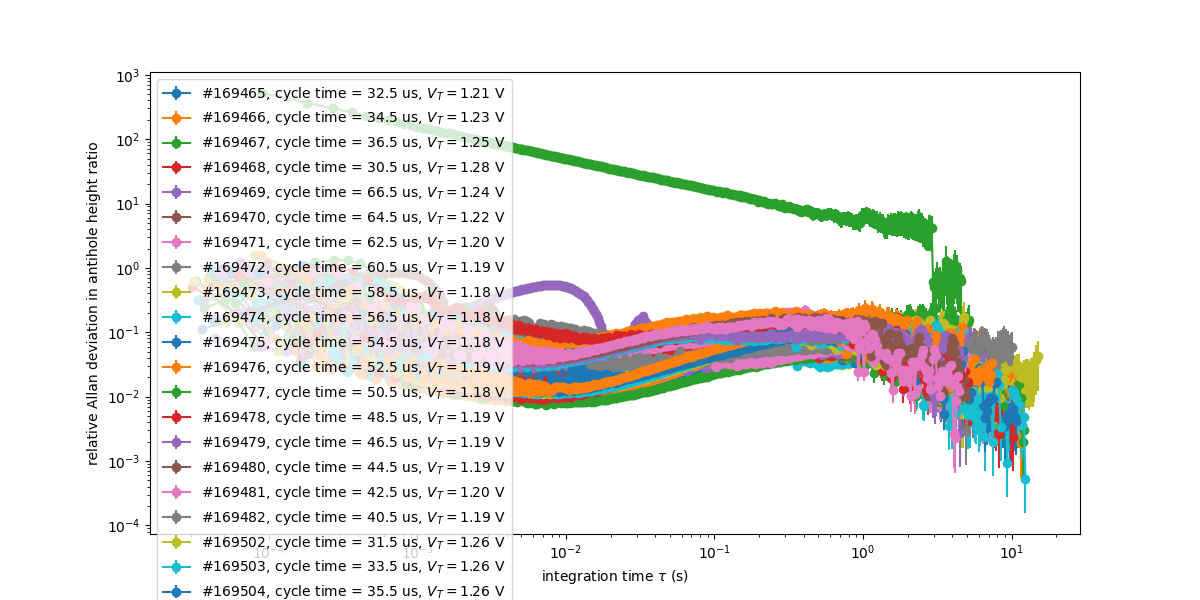

In [226]:
labels = dict([(kk, kk) for kk in range(169465, 169559)])
#labels = dict([(kk, kk) for kk in range(169527, 169532)])

fig, ax = plt.subplots(figsize=(12, 6))
for kk, label in enumerate(labels):
    data, headers = get_experiment_data(labels[label])  # 169455 - amp 210, 169456 - amp 160
    cycle_time = ((headers["params"]["detect"]["on_time"] * 2 + headers["params"]["detect"]["off_time"] * 2.5).to("s").magnitude) + 24e-6
    if cycle_time > 100e-6 or cycle_time <= 30e-6:
        continue
    cycles = headers["params"]["detect"]["cycles"]["antihole"]
    
    times = np.arange(cycles*100) * cycle_time
    ah_ratios = data["transmissions_avg"][:cycles*100,0] / data["transmissions_avg"][:cycles*100,1]
    rf_ratios = data["transmissions_avg"][cycles*100:cycles*100*2,0] / data["transmissions_avg"][cycles*100:cycles*100*2,1]
    ratios = (1-rf_ratios) / (1-ah_ratios + 1e-18)
    print(1- np.average(rf_ratios), 1- np.average(ah_ratios))
    
    fitter = Fitter(lambda x, a, b: a * x + b)
    fitter.set_data(times, ratios)
    fitter.fit()
    ratios_no_bg = ratios - fitter.fitted_value(times) + fitter.results["b"]
    fitter.set_data(times, ah_ratios)
    fitter.fit()
    ah_ratios_no_bg = ah_ratios - fitter.fitted_value(times) + fitter.results["b"]
    fitter.set_data(times, rf_ratios)
    fitter.fit()
    rf_ratios_no_bg = rf_ratios - fitter.fitted_value(times) + fitter.results["b"]
    plot_variable = np.copy(ratios_no_bg)
    
    plot_variable /= np.average(plot_variable)
    taus = np.logspace(0, np.log10(len(plot_variable) // 3), 500)
    real_taus, allan, allan_err, _ = allantools.adev(plot_variable, data_type="freq", taus=taus)
    #allan *= np.sqrt(np.average(data["transmissions_avg"]))
    #allan_err *= np.sqrt(np.average(data["transmissions_avg"]))
    real_taus *= cycle_time
    #ax.plot(real_taus, allan[0] / np.sqrt(real_taus / real_taus[0]), ls="--")
    ax.errorbar(real_taus, allan, allan_err, fmt="o", ls="-", label=f"#{headers['data_info']['data_number']}, cycle time = {cycle_time*1e6:.1f} us" + ", $V_T=" + f"{np.average(data["transmissions_avg"]):.2f}$ V")
    
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("integration time $\\tau$ (s)")
ax.set_ylabel("relative Allan deviation in antihole height ratio")
ax.legend()
plt.show()

1.1877559853305075
20.0 microsecond
-0.1960504299325463 -0.2160197536619184
0.05706485324258389


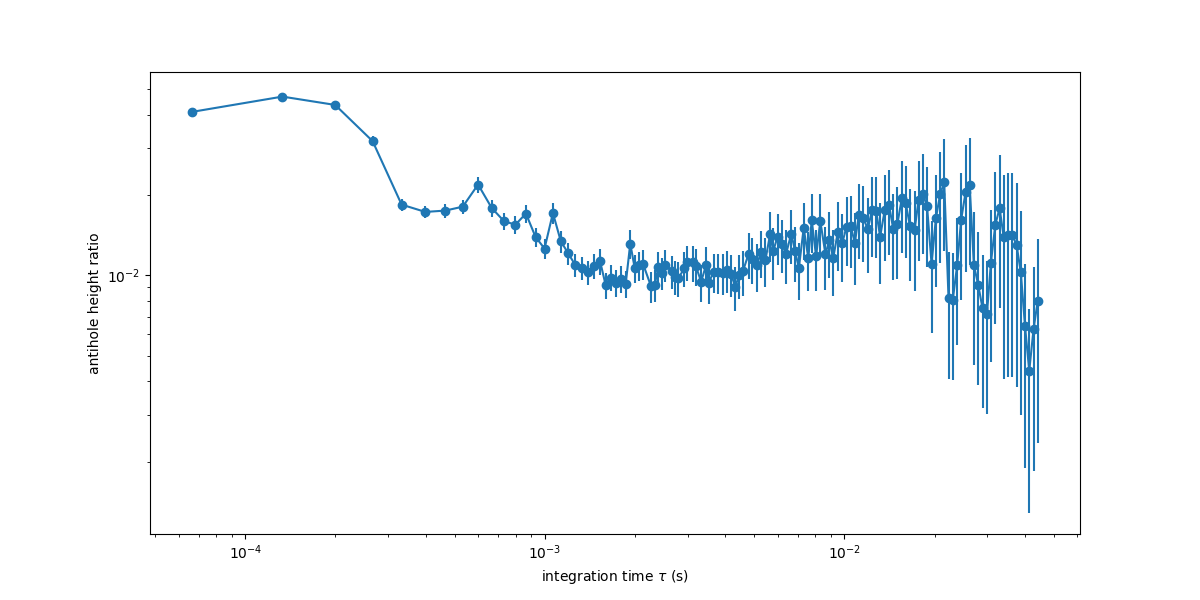

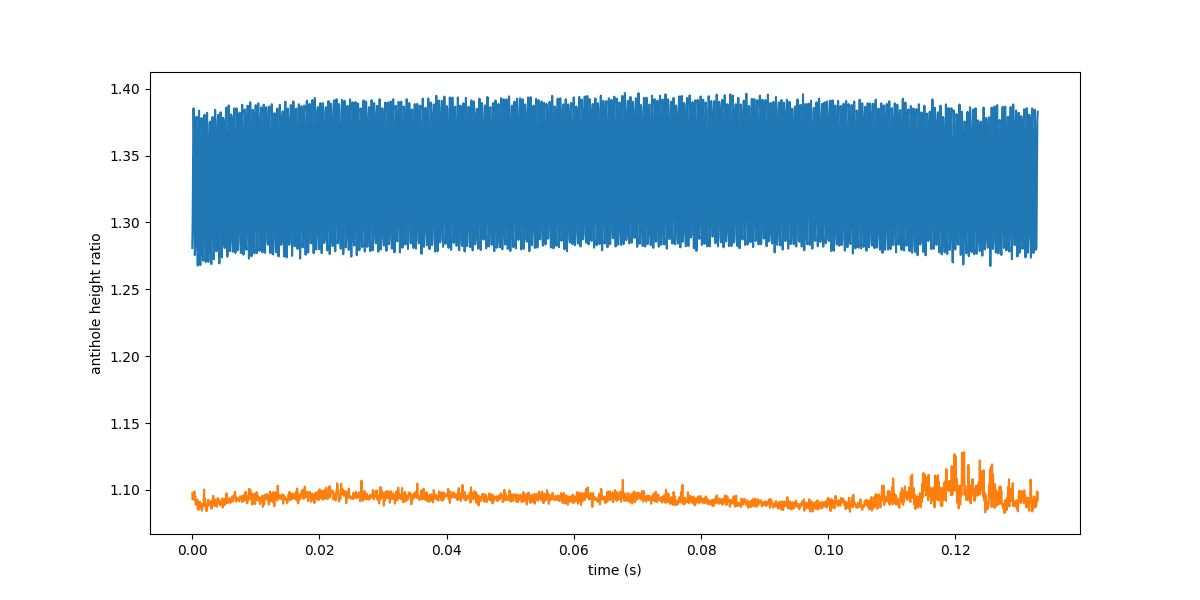

In [293]:
data, headers = get_experiment_data(169634)
print(np.average(data["transmissions_avg"]))

fitter = Fitter(lambda x, a, b: a * x + b)

cycle_time = ((headers["params"]["detect"]["on_time"] * 2 + headers["params"]["detect"]["off_time"] * 2.5).to("s").magnitude) + 24e-6
print(headers["params"]["detect"]["on_time"])
cycles = headers["params"]["detect"]["cycles"]["antihole"]

times = np.arange(cycles*100) * cycle_time
ah_ratios = data["transmissions_avg"][:cycles*100,0] / data["transmissions_avg"][:cycles*100,1]
rf_ratios = data["transmissions_avg"][cycles*100:cycles*100*2,0] / data["transmissions_avg"][cycles*100:cycles*100*2,1]
ratios = (1-rf_ratios) / (1-ah_ratios + 1e-18)
print(1- np.average(rf_ratios), 1- np.average(ah_ratios))
fitter.set_data(times, ratios)
fitter.fit()

fig, ax = plt.subplots(figsize=(12, 6))
#ax.plot(times, ratios)
#ax.plot(times, fitter.fitted_value(times))
ratios_no_bg = ratios - fitter.fitted_value(times) + fitter.results["b"]
fitter.set_data(times, ah_ratios)
fitter.fit()
ah_ratios_no_bg = ah_ratios - fitter.fitted_value(times) + fitter.results["b"]
fitter.set_data(times, data["transmissions_avg"][:cycles*100,0])
fitter.fit()
ah_on_res_no_bg = data["transmissions_avg"][:cycles*100,0] - fitter.fitted_value(times) + fitter.results["b"]
fitter.set_data(times, data["transmissions_avg"][:cycles*100,1])
fitter.fit()
ah_off_res_no_bg = data["transmissions_avg"][:cycles*100,1] - fitter.fitted_value(times) + fitter.results["b"]
fitter.set_data(times, rf_ratios)
fitter.fit()
rf_ratios_no_bg = rf_ratios - fitter.fitted_value(times) + fitter.results["b"]

plot_variable = np.copy(ratios_no_bg)
#ax.plot(times, plot_variable)
#ax.plot(times, ah_ratios_no_bg)
#ax.plot(times, rf_ratios_no_bg)
ax.plot(times, ah_on_res_no_bg)
ax.plot(times, ah_off_res_no_bg)
ax.set_xlabel("time (s)")
ax.set_ylabel("antihole height ratio")

plot_variable /= np.average(plot_variable)
print(np.std(plot_variable))
taus = np.logspace(0, np.log10(len(plot_variable) // 3), 200)
real_taus, allan, allan_err, _ = allantools.adev(plot_variable, data_type="freq", taus=taus)
real_taus *= cycle_time
fig, ax = plt.subplots(figsize=(12, 6))
ax.errorbar(real_taus, allan, allan_err, fmt="o", ls="-")
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("integration time $\\tau$ (s)")
ax.set_ylabel("antihole height ratio")
plt.show()

In [277]:
a = [1.28759765625, 1.359130859375, 1.356201171875, 1.394287109375, 1.361328125, 1.356689453125, 1.25634765625, 1.23193359375, 1.20263671875, 1.228515625, 1.18701171875, 1.1904296875, 1.1708984375, 1.2548828125, 1.185546875, 1.215576171875, 1.222412109375, 1.183837890625, 1.196044921875, 1.16455078125, 1.170654296875, 1.19482421875, 1.172607421875, 1.17236328125, 1.157470703125, 1.181396484375, 1.176513671875, 1.173828125, 1.185546875, 1.17626953125, 1.184326171875, 1.210693359375, 1.207275390625, 1.19873046875, 1.17626953125, 1.185302734375, 1.168701171875, 1.16552734375, 1.20556640625, 1.1826171875, 1.16796875, 1.19189453125, 1.158203125, 1.155517578125, 1.175048828125, 1.15625, 1.150390625, 1.201171875, 1.183837890625, 1.171142578125, 1.18115234375, 1.174560546875, 1.178955078125, 1.154052734375, 1.15087890625, 1.192626953125, 1.18896484375, 1.18359375, 1.1943359375, 1.142822265625, 1.14697265625, 1.160400390625, 1.170166015625, 1.1787109375, 1.184814453125, 1.198974609375, 1.1943359375, 1.177978515625, 1.166748046875, 1.17236328125, 1.19189453125, 1.174560546875, 1.165771484375, 1.206787109375, 1.225341796875, 1.19677734375, 1.158203125, 1.19677734375, 1.153076171875, 1.177978515625, 1.197265625, 1.177978515625, 1.1650390625, 1.1943359375, 1.173828125, 1.171142578125, 1.18798828125, 1.187255859375, 1.177490234375, 1.184814453125, 1.2041015625, 1.1630859375, 1.15234375, 1.15087890625, 1.188232421875, 1.172119140625, 1.15625, 1.140869140625, 1.14208984375, 1.159423828125, 1.1767578125, 1.17578125, 1.165283203125, 1.169921875, 1.163330078125, 1.15478515625, 1.16748046875, 1.161376953125, 1.163330078125, 1.17919921875, 1.1845703125, 1.1875, 1.162841796875, 1.1943359375, 1.1865234375, 1.18505859375, 1.170166015625, 1.18359375, 1.1767578125, 1.177734375, 1.168701171875, 1.1669921875, 1.1630859375, 1.18310546875, 1.185546875, 1.19189453125, 1.19287109375, 1.19677734375, 1.1552734375, 1.168701171875, 1.18701171875, 1.1494140625, 1.21142578125, 1.191162109375, 1.191162109375, 1.189208984375, 1.203857421875, 1.159423828125, 1.17724609375, 1.17236328125, 1.173583984375, 1.150146484375, 1.173828125, 1.20556640625, 1.156494140625, 1.16064453125, 1.18115234375, 1.18212890625, 1.15966796875, 1.178955078125, 1.181640625, 1.180419921875, 1.18603515625, 1.169677734375, 1.153076171875, 1.140625, 1.157958984375, 1.17822265625, 1.200927734375, 1.187255859375, 1.189208984375, 1.169921875, 1.16650390625, 1.171142578125, 1.1904296875, 1.152099609375, 1.207275390625, 1.185302734375, 1.171630859375, 1.16064453125, 1.18701171875, 1.18701171875, 1.167236328125, 1.16650390625, 1.1689453125, 1.167236328125, 1.17041015625, 1.170654296875, 1.20458984375, 1.169921875, 1.1943359375, 1.196044921875, 1.17333984375, 1.15673828125, 1.206298828125, 1.172607421875, 1.18994140625, 1.17529296875, 1.15673828125, 1.177001953125, 1.153076171875, 1.155517578125, 1.195556640625, 1.1796875, 1.17236328125, 1.182861328125, 1.145263671875, 1.16552734375, 1.1884765625, 1.160400390625, 1.1796875, 1.171630859375, 1.186279296875, 1.162353515625, 1.18701171875, 1.175537109375, 1.174072265625, 1.16650390625, 1.157958984375, 1.1875, 1.127685546875, 1.177734375, 1.151611328125, 1.18212890625, 1.205322265625, 1.173095703125, 1.179931640625, 1.15185546875, 1.187255859375, 1.172119140625, 1.18212890625, 1.166015625, 1.1708984375, 1.173828125, 1.173095703125, 1.170654296875, 1.19189453125, 1.17529296875, 1.140869140625, 1.1630859375, 1.1875, 1.20361328125, 1.16064453125, 1.1513671875, 1.17431640625, 1.171142578125, 1.18359375, 1.189453125, 1.197509765625, 1.213623046875, 1.189208984375, 1.181396484375, 1.16162109375, 1.17333984375, 1.188720703125, 1.18017578125, 1.205322265625, 1.183349609375, 1.216796875, 1.169189453125, 1.1884765625, 1.1806640625, 1.150390625, 1.185546875, 1.16064453125, 1.181396484375, 1.153076171875, 1.174072265625, 1.177978515625, 1.191650390625, 1.155029296875, 1.17431640625, 1.134521484375, 1.20361328125, 1.17724609375, 1.1708984375, 1.1630859375, 1.19775390625, 1.1943359375, 1.18212890625, 1.186279296875, 1.189697265625, 1.18212890625, 1.1884765625, 1.16015625, 1.17578125, 1.140625, 1.16259765625, 1.15625, 1.193115234375, 1.166748046875, 1.2001953125, 1.16748046875, 1.17578125, 1.163818359375, 1.175048828125, 1.205810546875, 1.19189453125, 1.233154296875, 1.242919921875, 1.17333984375, 1.190673828125, 1.197021484375, 1.1572265625, 1.191650390625, 1.154052734375, 1.168701171875, 1.15771484375, 1.18896484375, 1.171630859375, 1.1787109375, 1.186767578125, 1.168212890625, 1.1650390625, 1.17529296875, 1.19921875, 1.17724609375, 1.19189453125, 1.198486328125, 1.2060546875, 1.19482421875, 1.1796875, 1.14501953125, 1.1796875, 1.163330078125, 1.184814453125, 1.185546875, 1.146728515625, 1.16357421875, 1.197265625, 1.159912109375, 1.164794921875, 1.15087890625, 1.154052734375, 1.19775390625, 1.150634765625, 1.1708984375, 1.1923828125, 1.17431640625, 1.1845703125, 1.169921875, 1.210693359375, 1.186279296875, 1.20654296875, 1.150634765625, 1.158447265625, 1.177978515625, 1.161865234375, 1.1552734375, 1.153076171875, 1.161865234375, 1.163818359375, 1.138427734375, 1.171875, 1.16796875, 1.16455078125, 1.140869140625, 1.17431640625, 1.166015625, 1.14453125, 1.171875, 1.166259765625, 1.195556640625, 1.189697265625, 1.14697265625, 1.182861328125, 1.180908203125, 1.196044921875, 1.164306640625, 1.1748046875, 1.170654296875, 1.177978515625, 1.161376953125, 1.16943359375, 1.188232421875, 1.20556640625, 1.171630859375, 1.195556640625, 1.172607421875, 1.186279296875, 1.178466796875, 1.1669921875, 1.200439453125, 1.151611328125, 1.173095703125, 1.17626953125, 1.17724609375, 1.186767578125, 1.156982421875, 1.18701171875, 1.1669921875, 1.162109375, 1.201416015625, 1.16748046875, 1.19189453125, 1.192138671875, 1.169921875, 1.18408203125, 1.159912109375, 1.16943359375, 1.193359375, 1.187744140625, 1.174072265625, 1.15673828125, 1.153564453125, 1.181640625, 1.172607421875, 1.201171875, 1.148193359375, 1.20068359375, 1.18408203125, 1.194580078125, 1.1845703125, 1.18359375, 1.1865234375, 1.16650390625, 1.1923828125, 1.166015625, 1.1337890625, 1.15185546875, 1.1865234375, 1.158203125, 1.151123046875, 1.1533203125, 1.152587890625, 1.153564453125, 1.128173828125, 1.17236328125, 1.1826171875, 1.158447265625, 1.1591796875, 1.157470703125, 1.177978515625, 1.149169921875, 1.213134765625, 1.15771484375, 1.156005859375, 1.171630859375, 1.164794921875, 1.17236328125, 1.168701171875, 1.1904296875, 1.18115234375, 1.18701171875, 1.16357421875, 1.194091796875, 1.17822265625, 1.17529296875, 1.149169921875, 1.1572265625, 1.179931640625, 1.151611328125, 1.1689453125, 1.150390625, 1.167236328125, 1.208984375, 1.154541015625, 1.181640625, 1.153564453125, 1.175537109375, 1.14794921875, 1.14990234375, 1.14990234375, 1.1630859375, 1.175537109375, 1.157958984375, 1.140869140625, 1.125, 1.154296875, 1.179443359375, 1.185791015625, 1.131591796875, 1.19580078125, 1.151611328125, 1.16796875, 1.15869140625, 1.169677734375, 1.17822265625, 1.146484375, 1.135498046875, 1.14697265625, 1.159423828125, 1.143798828125, 1.181884765625, 1.1669921875, 1.153564453125, 1.186767578125, 1.20751953125, 1.176025390625, 1.1728515625, 1.180908203125, 1.166748046875, 1.163818359375, 1.16796875, 1.15380859375, 1.160400390625, 1.163818359375]

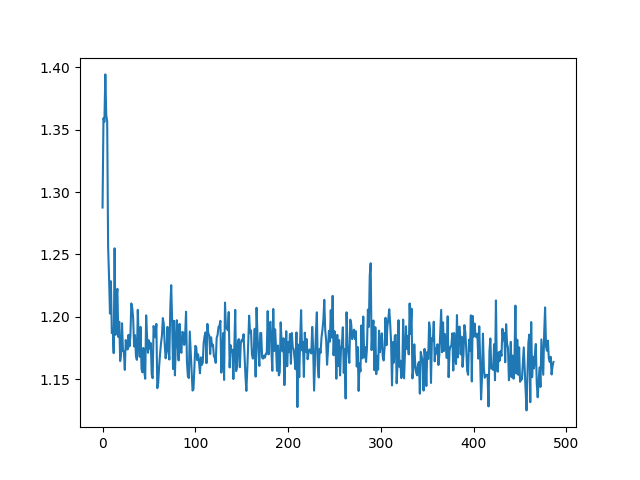

In [280]:
fig, ax = plt.subplots()
ax.plot(a)
plt.show()